# AIS Improvement Analysis 
### Effect of MAP, Sex, and Their Interaction

This notebook replicates the R workflow using **Python** on the simulated cohort.  In addition to classical logistic modelling, it includes 3‑D **Isomap** dimensionality‑reduction and **Topological Data Analysis (TDA)**.

> **Data file required**: `simulated_patients.csv` must live in the same folder as this notebook.

Outline:
1. Load & tidy the dataset  
2. Exploratory statistics  
3. Logistic model with `MAP × sex` interaction  
4. ROC analysis  
5. 2‑D PCA and 3‑D Isomap visualisations  
6. Persistence diagram & barcode (TDA)


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import statsmodels.formula.api as smf
from ripser import ripser
from persim import plot_diagrams
sns.set_theme(style="whitegrid")


## 1  Load & tidy

In [6]:
PATH = "simulated_patients.csv"  # adjust if necessary
df = (pd.read_csv(PATH)
        .dropna(subset=[
            "sex","ais_improved","mean_map_simulated",
            "age","ais_admission","ais_discharge",
            "surgery_duration_min","map_out_range_proportion"])
        .reset_index(drop=True))

df['sex'] = df['sex'].astype('category')
df['map_sq'] = df['mean_map_simulated']**2
df['delta_score'] = df['ais_discharge'] - df['ais_admission']

print(df.head())
print(f"Rows retained: {len(df)}")


   patient_id  age sex  ais_admission  ais_discharge  surgery_duration_min  \
0           1   66   M              1              2                   791   
1           2   39   M              3              3                   332   
2           3   33   M              4              4                   289   
3           4   84   F              2              2                   747   
4           5   29   M              1              1                   287   

   mean_map_simulated  map_out_range_proportion  ais_improved        map_sq  \
0          103.367442                  0.471910             1  10684.828134   
1           69.270721                  0.275281             0   4798.432737   
2           80.885123                  0.022472             0   6542.403052   
3           89.365290                  0.028090             0   7986.155036   
4           80.654257                  0.050562             0   6505.109190   

   delta_score  
0            1  
1            0  
2    

## 2  Exploratory statistics

/var/folders/n2/t_fg5h7n7rb0ysjgfhyq_m7c0000gn/T/ipykernel_43412/4031444060.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (impr := df.groupby('sex')['ais_improved'].mean()).plot.bar(color=['#1f77b4','#ff7f0e'])


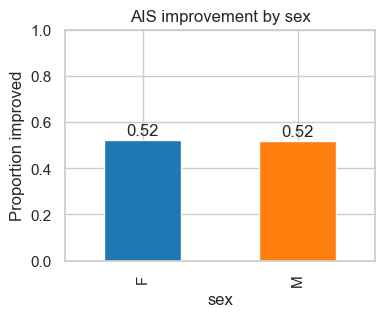

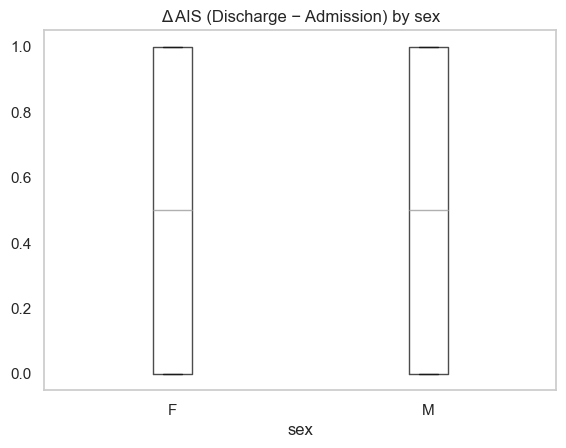

In [8]:
# Bar plot proportion improved by sex
plt.figure(figsize=(4,3))
(impr := df.groupby('sex')['ais_improved'].mean()).plot.bar(color=['#1f77b4','#ff7f0e'])
plt.ylim(0,1); plt.ylabel('Proportion improved'); plt.title('AIS improvement by sex')
for i, v in enumerate(impr):
    plt.text(i, v+0.02, f'{v:.2f}', ha='center')
plt.show()

# Boxplot of change in score
df.boxplot(column='delta_score', by='sex', grid=False)
plt.title('Δ AIS (Discharge − Admission) by sex'); plt.suptitle('')
plt.show()


## 3  Logistic regression with MAP × sex interaction

                           Logit Regression Results                           
Dep. Variable:           ais_improved   No. Observations:                  100
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            7
Date:                Sat, 07 Jun 2025   Pseudo R-squ.:                  0.1193
Time:                        02:05:01   Log-Likelihood:                -60.976
converged:                       True   LL-Null:                       -69.235
Covariance Type:            nonrobust   LLR p-value:                   0.02078
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.3314      3.647     -0.091      0.928      -7.480       6.817
sex[T.M]                       -7.1131      4.082     -1.742      0.081     -15.

,odds_ratio
Intercept,0.717901
sex[T.M],0.000814
mean_map_simulated,1.003793
mean_map_simulated:sex[T.M],1.087974
age,1.027984
surgery_duration_min,0.997699
map_out_range_proportion,3.817774
ais_admission,0.895111


/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


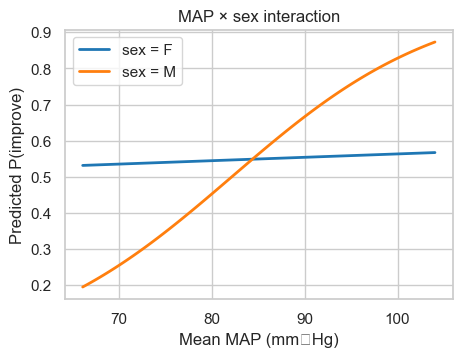

In [10]:
formula = ("ais_improved ~ mean_map_simulated * sex + "
           "age + surgery_duration_min + map_out_range_proportion + "
           "ais_admission")
model = smf.logit(formula, data=df).fit(disp=0)
print(model.summary())

# Odds ratios
or_table = np.exp(model.params).to_frame('odds_ratio')
display(or_table)

# Predicted curves by sex
grid = np.linspace(df['mean_map_simulated'].quantile(.01),
                   df['mean_map_simulated'].quantile(.99), 120)

plt.figure(figsize=(5,3.5))
for s, col in zip(df['sex'].cat.categories, ['#1f77b4','#ff7f0e']):
    tmp = pd.DataFrame({
        'mean_map_simulated': grid,
        'sex': s,
        'age': df['age'].median(),
        'surgery_duration_min': df['surgery_duration_min'].median(),
        'map_out_range_proportion': df['map_out_range_proportion'].median(),
        'ais_admission': df['ais_admission'].mode()[0]
    })
    plt.plot(grid, model.predict(tmp), color=col, label=f'sex = {s}', lw=2)
plt.xlabel('Mean MAP (mm Hg)'); plt.ylabel('Predicted P(improve)')
plt.title('MAP × sex interaction'); plt.legend(); plt.show()


## 4  ROC curve

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


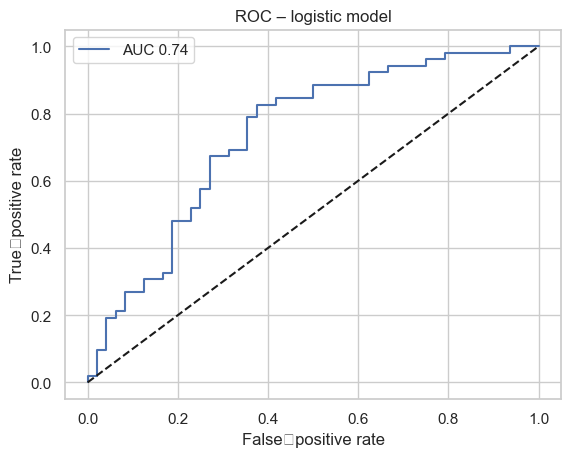

In [12]:
prob = model.predict(df)
fpr, tpr, _ = roc_curve(df['ais_improved'], prob)
plt.plot(fpr, tpr, label=f'AUC {auc(fpr,tpr):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False‑positive rate'); plt.ylabel('True‑positive rate')
plt.title('ROC – logistic model'); plt.legend(); plt.show()


## 5  Dimensionality reduction (PCA & 3‑D Isomap)

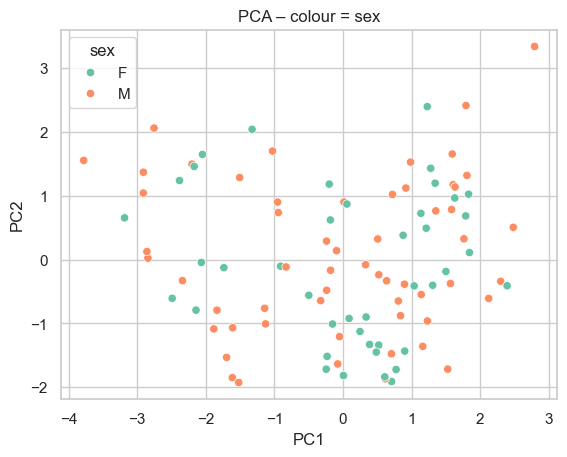

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


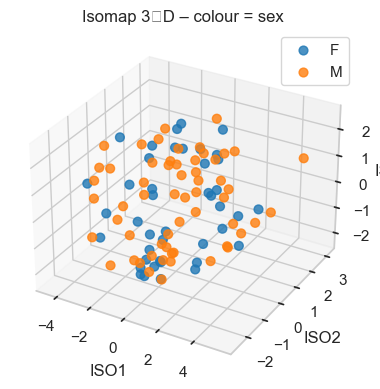

In [14]:
pred_cols = ['mean_map_simulated','map_sq','age',
             'surgery_duration_min','map_out_range_proportion','ais_admission']
X_scaled = StandardScaler().fit_transform(df[pred_cols])

# PCA 2‑D
pca = PCA(n_components=2).fit_transform(X_scaled)
df[['PC1','PC2']] = pca
sns.scatterplot(data=df, x='PC1', y='PC2', hue='sex', palette='Set2')
plt.title('PCA – colour = sex'); plt.show()

# 3‑D Isomap
iso = Isomap(n_neighbors=10, n_components=3).fit_transform(X_scaled)
df[['ISO1','ISO2','ISO3']] = iso

fig = plt.figure(figsize=(6,4.5)); ax = fig.add_subplot(111, projection='3d')
for s, col in zip(df['sex'].cat.categories, ['#1f77b4','#ff7f0e']):
    m = df['sex']==s
    ax.scatter(df.loc[m,'ISO1'], df.loc[m,'ISO2'], df.loc[m,'ISO3'],
               color=col, label=s, s=40, alpha=.8)
ax.set_xlabel('ISO1'); ax.set_ylabel('ISO2'); ax.set_zlabel('ISO3')
ax.set_title('Isomap 3‑D – colour = sex'); ax.legend(); plt.show()


## 6  Topological Data Analysis (Vietoris–Rips)

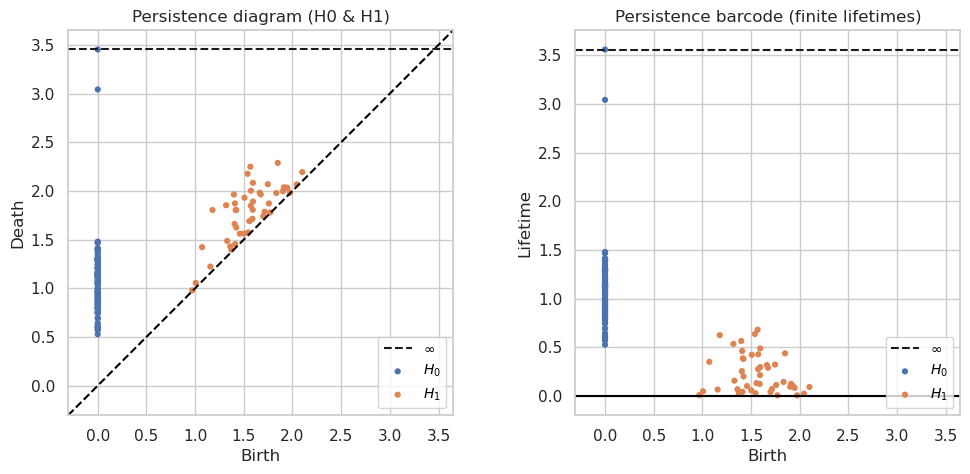

Finite‑bar total persistence (H0+H1): 114.740


In [16]:
tda = ripser(X_scaled, maxdim=1)
diagrams = tda['dgms']

fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_diagrams(diagrams, ax=ax[0], title='Persistence diagram (H0 & H1)')
plot_diagrams(diagrams, ax=ax[1], lifetime=True,
              title='Persistence barcode (finite lifetimes)')
plt.show()

finite = [d[np.isfinite(d[:,1])] for d in diagrams]
tot = sum((d[:,1]-d[:,0]).sum() for d in finite if len(d))
print(f'Finite‑bar total persistence (H0+H1): {tot:.3f}')
